In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Let's start by loading the Excel spreadsheets into pandas DataFrames. 

In [2]:
data_path = './data'
df_habits_raw = pd.read_excel(f'{data_path}/Habitos.xlsx', index_col=0).reset_index()

In [3]:
df_habits_raw.head()

,DS_IDENTIFICACION,Tipo,Habito2,Habito3,FE_INICIO,FE_FIN,DS_OBSERVACION,Fe_Registro
0,547351,ALCOHOL,BEBEDOR MODERADO,NaN,NaT,NaT,DIA POR MEDIO,2012-06-29
1,1123102,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2010-12-02
2,788432,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2014-02-20
3,885255,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2016-02-02
4,1261121,ALCOHOL,BEBEDOR MODERADO,NaN,NaT,NaT,NaN,2019-07-09


In [4]:
df_habits_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1931 entries, 0 to 1930
Data columns (total 8 columns):
DS_IDENTIFICACION    1931 non-null int64
Tipo                 1931 non-null object
Habito2              1930 non-null object
Habito3              123 non-null object
FE_INICIO            116 non-null datetime64[ns]
FE_FIN               28 non-null datetime64[ns]
DS_OBSERVACION       95 non-null object
Fe_Registro          1931 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(4)
memory usage: 120.8+ KB


In [5]:
df_habits_raw.columns = [col.lower() for col in df_habits_raw.columns]
df_habits_raw.rename(columns={
    'ds_identificacion': 'id_paciente',   
}, inplace=True)
df_habits_raw.head()

,id_paciente,tipo,habito2,habito3,fe_inicio,fe_fin,ds_observacion,fe_registro
0,547351,ALCOHOL,BEBEDOR MODERADO,NaN,NaT,NaT,DIA POR MEDIO,2012-06-29
1,1123102,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2010-12-02
2,788432,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2014-02-20
3,885255,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2016-02-02
4,1261121,ALCOHOL,BEBEDOR MODERADO,NaN,NaT,NaT,NaN,2019-07-09


In [6]:
df_habits_raw['habit_two'] = df_habits_raw.apply(lambda x: x['habito3'] if x['habito2'] == "SI" else x['habito2'], axis=1)


In [7]:
df_habits_raw.head()

,id_paciente,tipo,habito2,habito3,fe_inicio,fe_fin,ds_observacion,fe_registro,habit_two
0,547351,ALCOHOL,BEBEDOR MODERADO,NaN,NaT,NaT,DIA POR MEDIO,2012-06-29,BEBEDOR MODERADO
1,1123102,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2010-12-02,ABSTEMIO
2,788432,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2014-02-20,ABSTEMIO
3,885255,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2016-02-02,ABSTEMIO
4,1261121,ALCOHOL,BEBEDOR MODERADO,NaN,NaT,NaT,NaN,2019-07-09,BEBEDOR MODERADO


## New CSV to load in DB


In [56]:
df_clear_habits = df_habits_raw[['id_paciente', 'fe_registro', 'tipo', 'habit_two']].copy()

In [59]:
df_clear_habits.rename(columns={
    'id_paciente': 'id_patient',
    'tipo': 'habit_one', 
    'fe_registro':'registration_date'
}, inplace=True)
df_clear_habits.head()

,id_patient,registration_date,habit_one,habit_two
0,547351,2012-06-29,ALCOHOL,BEBEDOR MODERADO
1,1123102,2010-12-02,ALCOHOL,ABSTEMIO
2,788432,2014-02-20,ALCOHOL,ABSTEMIO
3,885255,2016-02-02,ALCOHOL,ABSTEMIO
4,1261121,2019-07-09,ALCOHOL,BEBEDOR MODERADO


In [58]:
df_clear_habits.to_csv('./data/cleansed/habits.csv')

## EDA

In [8]:
df_3 = df_habits_raw[['id_paciente', 'fe_registro', 'tipo', 'habit_two']].groupby(by = ['id_paciente', 'fe_registro', 'tipo'], as_index = False).first()
df_3['new_id'] = df_3['id_paciente'].apply(lambda x: str(x)+" ") + df_3['fe_registro'].apply(lambda x: x.strftime('%Y-%m-%d'))
df_3.head()

,id_paciente,fe_registro,tipo,habit_two,new_id
0,500588,2017-09-13,METODO DE PLANIFICACION,NO APLICA,500588 2017-09-13
1,502989,2017-08-31,METODO DE PLANIFICACION,EL CONDON,502989 2017-08-31
2,506808,2014-12-16,CIGARRILLO,NO,506808 2014-12-16
3,506808,2014-12-16,MASCOTAS,AVES,506808 2014-12-16
4,506808,2017-09-07,METODO DE PLANIFICACION,NO APLICA,506808 2017-09-07


df_clear_habits.rename(columns={
    'tipo': 'habit_one', 
    'habito2': 'habit_two', 
    'fe_registro':'registration_date'
}, inplace=True)
df_clear_habits.head()

In [12]:
df_4 = df_3.pivot(index='new_id', columns='tipo', values='habit_two') 
df_4.head()

tipo,ALCOHOL,ALIMENTACION,CIGARRILLO,CONSUMO DE CAFE,EJERCICIO,ESTADO ANÍMICO,MASCOTAS,METODO DE PLANIFICACION,SUSTANCIAS PSICOACTIVAS
new_id,,,,,,,,,
1001619 2011-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IMPLANTE SUBDERMICO,NaN
1001619 2012-07-12,BEBEDOR EXCEPCIONAL,BUENA ALIMENTACION,NO,NaN,1 VEZ POR SEMANA,NaN,NO,NaN,NaN
1004538 2015-08-25,ABSTEMIO,BUENA ALIMENTACION,NO,NaN,3 VECES POR SEMANA,NaN,NaN,NaN,NaN
1004538 2017-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HISTERECTOMIA,NaN
1008837 2011-03-18,NaN,REGULAR ALIMENTACION,NaN,NaN,NO REALIZA EJERCICIO,ANIMICAMENTE ESTABLE,NO,NaN,NaN


In [13]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 856 entries, 1001619 2011-11-01 to 998153 2017-09-14
Data columns (total 9 columns):
ALCOHOL                    279 non-null object
ALIMENTACION               182 non-null object
CIGARRILLO                 341 non-null object
CONSUMO DE CAFE            111 non-null object
EJERCICIO                  257 non-null object
ESTADO ANÍMICO             98 non-null object
MASCOTAS                   154 non-null object
METODO DE PLANIFICACION    442 non-null object
SUSTANCIAS PSICOACTIVAS    46 non-null object
dtypes: object(9)
memory usage: 66.9+ KB


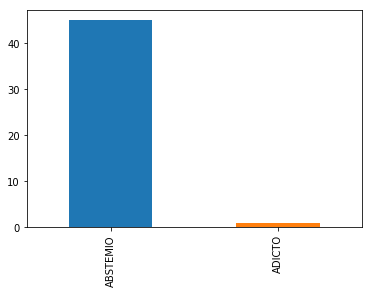

In [14]:
df_4['SUSTANCIAS PSICOACTIVAS'].value_counts().plot.bar()

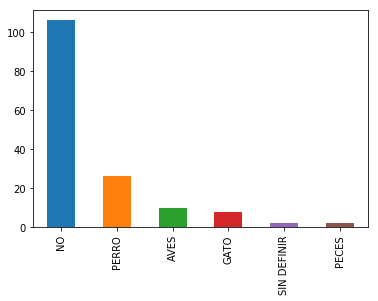

In [15]:
df_4['MASCOTAS'].value_counts().plot.bar()

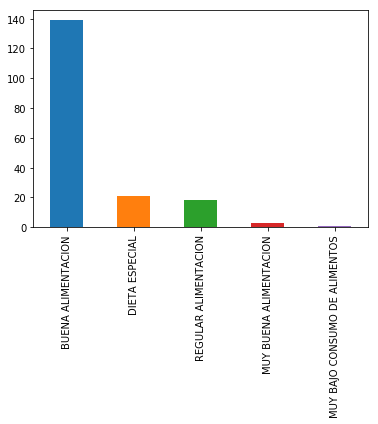

In [16]:
df_4['ALIMENTACION'].value_counts().plot.bar()

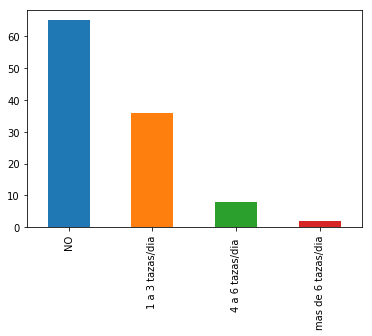

In [17]:
df_4['CONSUMO DE CAFE'].value_counts().plot.bar()

In [18]:
df_5 = df_4
for var in df_4.columns:
    #pd.get_dummies(df_4[var])
    df_5 = pd.concat([df_5, pd.get_dummies(df_4[var], prefix = var + " | ")], axis=1, sort=False)
df_corr = df_5.corr()

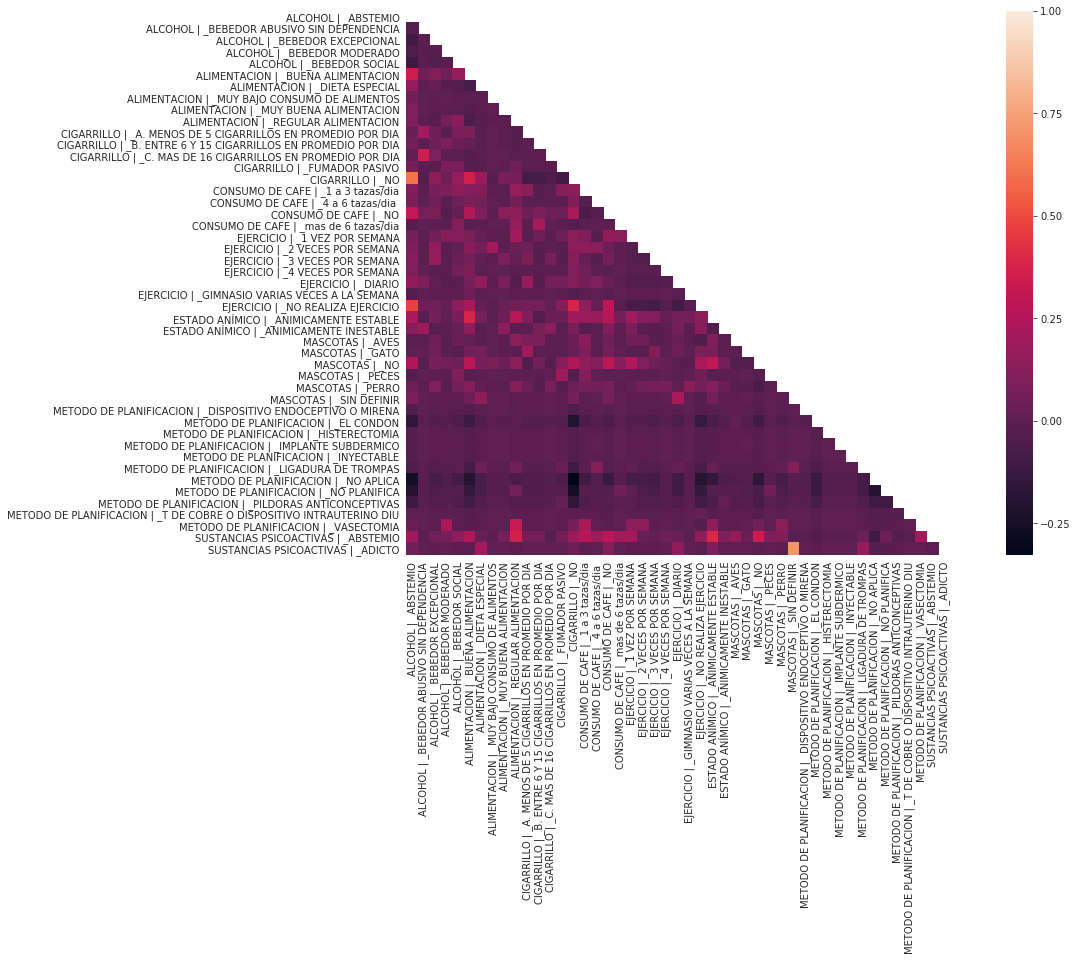

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))


mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    p2 = sns.heatmap(df_corr, mask=mask, square=True)


In [20]:
df_corr_2 = df_corr.stack().reset_index()
#df_corr_2.sort_values(ascending = False).head()
df_corr_2[df_corr_2[0]!=1].sort_values(by = 0, ascending = False)

,level_0,level_1,0
1597,MASCOTAS | _SIN DEFINIR,SUSTANCIAS PSICOACTIVAS | _ADICTO,0.706693
2195,SUSTANCIAS PSICOACTIVAS | _ADICTO,MASCOTAS | _SIN DEFINIR,0.706693
658,CIGARRILLO | _NO,ALCOHOL | _ABSTEMIO,0.608859
14,ALCOHOL | _ABSTEMIO,CIGARRILLO | _NO,0.608859
1175,EJERCICIO | _NO REALIZA EJERCICIO,ALCOHOL | _ABSTEMIO,0.479708
25,ALCOHOL | _ABSTEMIO,EJERCICIO | _NO REALIZA EJERCICIO,0.479708
1267,ESTADO ANÍMICO | _ANIMICAMENTE ESTABLE,SUSTANCIAS PSICOACTIVAS | _ABSTEMIO,0.394377
2141,SUSTANCIAS PSICOACTIVAS | _ABSTEMIO,ESTADO ANÍMICO | _ANIMICAMENTE ESTABLE,0.394377
1227,ESTADO ANÍMICO | _ANIMICAMENTE ESTABLE,ALIMENTACION | _BUENA ALIMENTACION,0.383396
261,ALIMENTACION | _BUENA ALIMENTACION,ESTADO ANÍMICO | _ANIMICAMENTE ESTABLE,0.383396


In [21]:
df_habits_raw['tipo'].unique()

array(['ALCOHOL', 'ALIMENTACION', 'CIGARRILLO', 'CONSUMO DE CAFE',
       'EJERCICIO', 'ESTADO ANÍMICO', 'MASCOTAS',
       'METODO DE PLANIFICACION', 'SUSTANCIAS PSICOACTIVAS'], dtype=object)

In [22]:
df_habits_raw['habito2'].unique()

array(['BEBEDOR MODERADO', 'ABSTEMIO', 'BEBEDOR ABUSIVO SIN DEPENDENCIA',
       'BEBEDOR SOCIAL', 'BEBEDOR EXCEPCIONAL', 'BUENA ALIMENTACION',
       'REGULAR ALIMENTACION', 'DIETA ESPECIAL', 'MUY BUENA ALIMENTACION',
       'MUY BAJO CONSUMO DE ALIMENTOS', 'FUMADOR PASIVO', 'NO', 'SI',
       'NO REALIZA EJERCICIO', '1 VEZ POR SEMANA', 'DIARIO',
       '2 VECES POR SEMANA', '3 VECES POR SEMANA', '4 VECES POR SEMANA',
       'GIMNASIO VARIAS VECES A LA SEMANA', 'ANIMICAMENTE ESTABLE',
       'ANIMICAMENTE INESTABLE', nan, 'SIN DEFINIR', 'NO PLANIFICA',
       'EL CONDON', 'VASECTOMIA', 'NO APLICA', 'LIGADURA DE TROMPAS',
       'PILDORAS ANTICONCEPTIVAS', 'DISPOSITIVO ENDOCEPTIVO O MIRENA',
       'HISTERECTOMIA', 'INYECTABLE',
       'T DE COBRE O DISPOSITIVO INTRAUTERINO DIU', 'IMPLANTE SUBDERMICO',
       'ADICTO'], dtype=object)

In [23]:
df_habits_raw['habito3'].unique()

array([nan, 'B. ENTRE 6 Y 15 CIGARRILLOS EN PROMEDIO POR DIA',
       'C. MAS DE 16 CIGARRILLOS EN PROMEDIO POR DIA',
       'A. MENOS DE 5 CIGARRILLOS EN PROMEDIO POR DIA', '1 a 3 tazas/dia',
       '4 a 6 tazas/dia ', 'mas de 6 tazas/dia', 'PERRO', 'PECES', 'GATO',
       'AVES', 'SIN DEFINIR'], dtype=object)

In [24]:
df_habits_raw.drop_duplicates(inplace=True)

In [25]:
df_habits_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1931 entries, 0 to 1930
Data columns (total 9 columns):
id_paciente       1931 non-null int64
tipo              1931 non-null object
habito2           1930 non-null object
habito3           123 non-null object
fe_inicio         116 non-null datetime64[ns]
fe_fin            28 non-null datetime64[ns]
ds_observacion    95 non-null object
fe_registro       1931 non-null datetime64[ns]
habit_two         1917 non-null object
dtypes: datetime64[ns](3), int64(1), object(5)
memory usage: 150.9+ KB


In [26]:
df_habits_raw.head()

,id_paciente,tipo,habito2,habito3,fe_inicio,fe_fin,ds_observacion,fe_registro,habit_two
0,547351,ALCOHOL,BEBEDOR MODERADO,NaN,NaT,NaT,DIA POR MEDIO,2012-06-29,BEBEDOR MODERADO
1,1123102,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2010-12-02,ABSTEMIO
2,788432,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2014-02-20,ABSTEMIO
3,885255,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2016-02-02,ABSTEMIO
4,1261121,ALCOHOL,BEBEDOR MODERADO,NaN,NaT,NaT,NaN,2019-07-09,BEBEDOR MODERADO


#### Total number of patients

In [27]:
len(df_habits_raw['id_paciente'].unique())

519

#### Period

In [28]:
df_habits_raw['fe_registro'].describe()

count                    1931
unique                    378
top       2017-09-13 00:00:00
freq                      162
first     2010-11-25 00:00:00
last      2020-03-27 00:00:00
Name: fe_registro, dtype: object

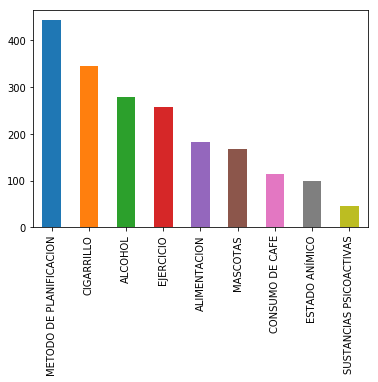

In [29]:
df_habits_raw['tipo'].value_counts()
df_habits_raw['tipo'].value_counts().plot.bar()

In [30]:
df_habits_raw['tipo'].value_counts()

METODO DE PLANIFICACION    443
CIGARRILLO                 344
ALCOHOL                    279
EJERCICIO                  257
ALIMENTACION               182
MASCOTAS                   167
CONSUMO DE CAFE            114
ESTADO ANÍMICO              99
SUSTANCIAS PSICOACTIVAS     46
Name: tipo, dtype: int64

In [31]:
#df_habits_raw['id_paciente'].value_counts().value_counts().plot.bar()

In [32]:
df_habits_raw['id_paciente'].value_counts()

1437443    16
1028001    16
1226479    16
692765     14
1764814    13
1132214    13
1505589    13
1668828    12
1884922    12
1730455    12
1537618    12
1343127    12
832593     12
1617372    12
526049     11
1048877    11
1715065    11
1199605    10
1220399    10
1744661    10
1969148    10
739693     10
1181123    10
1664806    10
1394607    10
1463545    10
1446076    10
1022734    10
801004      9
1019152     9
           ..
1071544     1
1319348     1
1795441     1
1548056     1
709830      1
1099067     1
1796703     1
677707      1
1241688     1
1691670     1
1563221     1
502989      1
746711      1
1893592     1
1729099     1
978163      1
1854024     1
941311      1
968220      1
1198654     1
1804207     1
975419      1
1821242     1
929046      1
1729074     1
1647150     1
1807645     1
1976243     1
1460766     1
1437167     1
Name: id_paciente, Length: 519, dtype: int64

In [33]:
df_habits_raw['habito2'].value_counts()

NO                                           475
ABSTEMIO                                     259
NO APLICA                                    144
NO PLANIFICA                                 140
BUENA ALIMENTACION                           139
NO REALIZA EJERCICIO                         136
SI                                           136
ANIMICAMENTE ESTABLE                          85
EL CONDON                                     65
PILDORAS ANTICONCEPTIVAS                      45
DIARIO                                        37
BEBEDOR SOCIAL                                32
LIGADURA DE TROMPAS                           31
3 VECES POR SEMANA                            30
1 VEZ POR SEMANA                              25
BEBEDOR EXCEPCIONAL                           22
2 VECES POR SEMANA                            22
DIETA ESPECIAL                                21
REGULAR ALIMENTACION                          18
ANIMICAMENTE INESTABLE                        13
FUMADOR PASIVO      

In [34]:
df_habits_raw['habito3'].value_counts()

1 a 3 tazas/dia                                    36
PERRO                                              27
A. MENOS DE 5 CIGARRILLOS EN PROMEDIO POR DIA      11
AVES                                               10
B. ENTRE 6 Y 15 CIGARRILLOS EN PROMEDIO POR DIA    10
GATO                                               10
4 a 6 tazas/dia                                     8
C. MAS DE 16 CIGARRILLOS EN PROMEDIO POR DIA        4
PECES                                               3
SIN DEFINIR                                         2
mas de 6 tazas/dia                                  2
Name: habito3, dtype: int64

In [35]:
df_habits_raw[['tipo', 'habito2', 'id_paciente']].groupby(by=['tipo', 'habito2'], as_index=False).count()

,tipo,habito2,id_paciente
0,ALCOHOL,ABSTEMIO,214
1,ALCOHOL,BEBEDOR ABUSIVO SIN DEPENDENCIA,2
2,ALCOHOL,BEBEDOR EXCEPCIONAL,22
3,ALCOHOL,BEBEDOR MODERADO,9
4,ALCOHOL,BEBEDOR SOCIAL,32
5,ALIMENTACION,BUENA ALIMENTACION,139
6,ALIMENTACION,DIETA ESPECIAL,21
7,ALIMENTACION,MUY BAJO CONSUMO DE ALIMENTOS,1
8,ALIMENTACION,MUY BUENA ALIMENTACION,3
9,ALIMENTACION,REGULAR ALIMENTACION,18


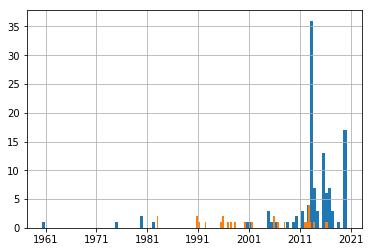

In [36]:
df_habits_raw['fe_inicio'].hist(bins=100)
df_habits_raw['fe_fin'].hist(bins=100)

In [37]:
#df_habits_raw['e_Registro'].hist(bins=100)

In [38]:
df_habits_raw['fe_registro'].describe()

count                    1931
unique                    378
top       2017-09-13 00:00:00
freq                      162
first     2010-11-25 00:00:00
last      2020-03-27 00:00:00
Name: fe_registro, dtype: object

In [39]:
df_habits_raw[['id_paciente', 'tipo']].shape

(1931, 2)

In [40]:
df_habits_raw[['id_paciente', 'tipo']].drop_duplicates().shape

(1763, 2)

In [41]:
df_habits_raw[['id_paciente', 'tipo', 'habito2']].shape

(1931, 3)

In [42]:
df_habits_raw[['id_paciente', 'tipo', 'habito2', 'fe_registro']].shape

(1931, 4)

In [43]:
df_habits_raw[['id_paciente', 'tipo', 'habito2']].drop_duplicates().shape

(1820, 3)

In [44]:
df_habits_raw[['id_paciente', 'tipo', 'habito2', 'fe_registro']].drop_duplicates().shape

(1925, 4)

In [45]:
df_habits_raw.groupby(by=['id_paciente', 'tipo'], as_index=False).count().sort_values(by='fe_registro',ascending=False)

,id_paciente,tipo,habito2,habito3,fe_inicio,fe_fin,ds_observacion,fe_registro,habit_two
210,692765,CIGARRILLO,5,1,0,2,1,5,5
864,1226479,MASCOTAS,5,2,1,0,1,5,5
1438,1715065,MASCOTAS,3,3,1,0,0,3,3
1088,1437443,CIGARRILLO,3,0,0,0,0,3,3
1234,1536265,METODO DE PLANIFICACION,3,0,2,0,0,3,3
589,1028001,CIGARRILLO,3,0,0,0,0,3,3
860,1226479,CIGARRILLO,3,0,0,0,0,3,3
1087,1437443,ALIMENTACION,3,0,0,0,1,3,3
212,692765,EJERCICIO,3,0,0,0,1,3,3
371,832593,EJERCICIO,3,0,3,0,0,3,3


In [46]:
df_habits_raw[df_habits_raw['id_paciente']==692765].sort_values(by='fe_registro')

,id_paciente,tipo,habito2,habito3,fe_inicio,fe_fin,ds_observacion,fe_registro,habit_two
199,692765,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2014-02-18,ABSTEMIO
695,692765,CIGARRILLO,NO,NaN,NaT,NaT,NaN,2014-02-18,NO
1091,692765,EJERCICIO,NO REALIZA EJERCICIO,NaN,NaT,NaT,NaN,2014-02-18,NO REALIZA EJERCICIO
398,692765,ALIMENTACION,DIETA ESPECIAL,NaN,NaT,NaT,NUTRICIONISTA,2014-03-02,DIETA ESPECIAL
885,692765,CONSUMO DE CAFE,NO,NaN,NaT,NaT,NaN,2014-03-02,NO
699,692765,CIGARRILLO,SI,A. MENOS DE 5 CIGARRILLOS EN PROMEDIO POR DIA,NaT,NaT,hace muchos años no fuma,2014-10-07,A. MENOS DE 5 CIGARRILLOS EN PROMEDIO POR DIA
1090,692765,EJERCICIO,DIARIO,NaN,NaT,NaT,"camina bastante, terapias respiratorias 3 vece...",2014-10-07,DIARIO
696,692765,CIGARRILLO,NO,NaN,NaT,1990-10-01,NaN,2015-10-30,NO
886,692765,CONSUMO DE CAFE,SI,4 a 6 tazas/dia,NaT,NaT,NaN,2015-10-30,4 a 6 tazas/dia
200,692765,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2015-11-12,ABSTEMIO


In [47]:
df_habits_raw[['id_paciente', 'tipo', 'habito2', 'fe_registro']].shape

(1931, 4)

In [48]:
df_habits_raw[['id_paciente', 'tipo', 'habito2', 'fe_registro']].drop_duplicates().shape

(1925, 4)

In [49]:
df_habits_raw['flag'] = 'S'
df_habits_raw

,id_paciente,tipo,habito2,habito3,fe_inicio,fe_fin,ds_observacion,fe_registro,habit_two,flag
0,547351,ALCOHOL,BEBEDOR MODERADO,NaN,NaT,NaT,DIA POR MEDIO,2012-06-29,BEBEDOR MODERADO,S
1,1123102,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2010-12-02,ABSTEMIO,S
2,788432,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2014-02-20,ABSTEMIO,S
3,885255,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2016-02-02,ABSTEMIO,S
4,1261121,ALCOHOL,BEBEDOR MODERADO,NaN,NaT,NaT,NaN,2019-07-09,BEBEDOR MODERADO,S
5,1487899,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2016-01-29,ABSTEMIO,S
6,1874742,ALCOHOL,BEBEDOR ABUSIVO SIN DEPENDENCIA,NaN,NaT,2001-09-19,NaN,2011-09-14,BEBEDOR ABUSIVO SIN DEPENDENCIA,S
7,1487208,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2012-07-31,ABSTEMIO,S
8,1487208,ALCOHOL,ABSTEMIO,NaN,2013-06-26,NaT,NaN,2013-06-28,ABSTEMIO,S
9,1764814,ALCOHOL,BEBEDOR MODERADO,NaN,NaT,NaT,NaN,2011-08-25,BEBEDOR MODERADO,S


In [50]:
df_habits_raw.groupby(by=['id_paciente', 'tipo', 'habito2', 'fe_registro'], as_index=False).count().sort_values(by='flag',ascending=False)

,id_paciente,tipo,habito2,fe_registro,habito3,fe_inicio,fe_fin,ds_observacion,habit_two,flag
1909,1995612,MASCOTAS,SI,2014-11-06,2,0,0,0,2,2
1567,1715065,MASCOTAS,SI,2014-04-08,2,0,0,0,2,2
935,1226479,MASCOTAS,SIN DEFINIR,2016-02-03,0,0,0,1,2,2
805,1128432,MASCOTAS,SI,2014-06-20,2,0,0,0,2,2
854,1181123,MASCOTAS,SI,2014-01-03,2,0,0,0,2,2
1341,1536265,METODO DE PLANIFICACION,NO APLICA,2017-09-13,0,1,0,0,2,2
0,500588,METODO DE PLANIFICACION,NO APLICA,2017-09-13,0,0,0,0,1,1
1283,1492864,EJERCICIO,NO REALIZA EJERCICIO,2013-07-29,0,0,0,0,1,1
1281,1492864,CIGARRILLO,SI,2013-07-29,1,0,0,1,1,1
1282,1492864,CONSUMO DE CAFE,NO,2013-07-29,0,0,0,0,1,1


In [51]:
df_clear_habits = df_habits_raw[['id_paciente', 'tipo', 'habito2', 'fe_registro']].copy()
df_clear_habits.drop_duplicates(inplace=True)
df_clear_habits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1925 entries, 0 to 1930
Data columns (total 4 columns):
id_paciente    1925 non-null int64
tipo           1925 non-null object
habito2        1924 non-null object
fe_registro    1925 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 75.2+ KB


In [52]:
df_clear_habits.rename(columns={
    'tipo': 'habit_one', 
    'habito2': 'habit_two', 
    'fe_registro':'registration_date'
}, inplace=True)
df_clear_habits.head()

,id_paciente,habit_one,habit_two,registration_date
0,547351,ALCOHOL,BEBEDOR MODERADO,2012-06-29
1,1123102,ALCOHOL,ABSTEMIO,2010-12-02
2,788432,ALCOHOL,ABSTEMIO,2014-02-20
3,885255,ALCOHOL,ABSTEMIO,2016-02-02
4,1261121,ALCOHOL,BEBEDOR MODERADO,2019-07-09


In [53]:
#df_clear_habits.to_csv('./data/cleansed/habits.csv')

In [54]:
df_habits_raw[df_habits_raw['id_paciente']==1995612].sort_values(by='fe_registro')

,id_paciente,tipo,habito2,habito3,fe_inicio,fe_fin,ds_observacion,fe_registro,habit_two,flag
132,1995612,ALCOHOL,ABSTEMIO,NaN,NaT,NaT,NaN,2014-11-06,ABSTEMIO,S
615,1995612,CIGARRILLO,SI,C. MAS DE 16 CIGARRILLOS EN PROMEDIO POR DIA,NaT,1996-11-01,NaN,2014-11-06,C. MAS DE 16 CIGARRILLOS EN PROMEDIO POR DIA,S
851,1995612,CONSUMO DE CAFE,NO,NaN,NaT,NaT,NaN,2014-11-06,NO,S
1032,1995612,EJERCICIO,3 VECES POR SEMANA,NaN,NaT,NaT,NaN,2014-11-06,3 VECES POR SEMANA,S
1226,1995612,ESTADO ANÍMICO,ANIMICAMENTE ESTABLE,NaN,NaT,NaT,NaN,2014-11-06,ANIMICAMENTE ESTABLE,S
1329,1995612,MASCOTAS,SI,PERRO,NaT,NaT,NaN,2014-11-06,PERRO,S
1330,1995612,MASCOTAS,SI,GATO,NaT,NaT,NaN,2014-11-06,GATO,S
1590,1995612,METODO DE PLANIFICACION,NO APLICA,NaN,NaT,NaT,NaN,2017-09-13,NO APLICA,S


In [55]:
df_habits_raw[df_habits_raw['tipo']=='METODO DE PLANIFICACION'].value_counts()
df_habits_raw[df_habits_raw['tipo']=='METODO DE PLANIFICACION'].value_counts().plot.bar()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [ ]:
df_habits_raw[df_habits_raw['tipo']=='METODO DE PLANIFICACION']['habito2'].value_counts()
df_habits_raw[df_habits_raw['tipo']=='METODO DE PLANIFICACION']['habito2'].value_counts().plot.bar(kind='barh', x='Examenes de laboratorio')

In [ ]:
df_habits_raw[df_habits_raw['tipo']=='CIGARRILLO']['habito3'].value_counts().plot.bar()

In [ ]:
df_habits_raw[df_habits_raw['tipo']=='ALCOHOL']['habito2'].value_counts().plot.bar()

In [ ]:
df_habits_raw[df_habits_raw['tipo']=='EJERCICIO']['habito2'].value_counts().plot.bar()

In [ ]:
df_habits_raw[df_habits_raw['tipo']=='CONSUMO DE CAFE']['habito3'].value_counts().plot.bar()

In [ ]:
df_habits_raw[df_habits_raw['tipo']=='ESTADO ANÍMICO']['habito2'].value_counts().plot.bar()

In [ ]:
df_habits_raw[df_habits_raw['tipo']=='ALIMENTACION']['habito2'].value_counts().plot.bar()